In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import zipfile

from google.colab import drive, files
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import categorical_crossentropy
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dir = '/content/gdrive/MyDrive/Colab Notebooks/Birds/data'
filepaths = []
labels = []

folds = os.listdir(dir)
for fold in folds:
    foldpath = os.path.join(dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=1)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 16
img_size = (258, 258)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)
valid_gen = train_datagen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)
test_gen = train_datagen.flow_from_dataframe(test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)
class_names = list(train_gen.class_indices.keys())

Found 528 validated image filenames belonging to 2 classes.
Found 133 validated image filenames belonging to 2 classes.
Found 165 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# Определение архитектуры нейронной сети
model = Sequential()

# Сверточные слои
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=img_shape))
model.add(MaxPooling2D((2, 2)))

# Преобразование трехмерных карт признаков в одномерный вектор
model.add(Flatten())

# Полносвязные слои
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Выходной слой
model.add(Dense(2, activation='sigmoid'))

# Компиляция модели
model.compile(Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Вывод структуры модели
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 1048576)           0         
                                                                 
 dense_30 (Dense)            (None, 128)               134217856 
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 2)                 258       
                                                     

In [ ]:
# Обучение модели
history = model.fit(
    train_gen,
    epochs = 10,  # Количество эпох обучения
    validation_data = valid_gen
)

# Оценка точности на тестовом наборе данных
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Test Accuracy: {test_accuracy} Loss: {test_loss}')

Epoch 1/10
33/33 [==============================] - 90s 3s/step - loss: 11.5682 - accuracy: 0.5852 - val_loss: 0.6184 - val_accuracy: 0.6842
Epoch 2/10
33/33 [==============================] - 86s 3s/step - loss: 0.5269 - accuracy: 0.7121 - val_loss: 0.5515 - val_accuracy: 0.7744
Epoch 3/10
33/33 [==============================] - 78s 2s/step - loss: 0.5744 - accuracy: 0.6780 - val_loss: 0.6365 - val_accuracy: 0.7068
Epoch 4/10
33/33 [==============================] - 77s 2s/step - loss: 0.4975 - accuracy: 0.7633 - val_loss: 0.6191 - val_accuracy: 0.7368
Epoch 5/10
33/33 [==============================] - 77s 2s/step - loss: 0.5710 - accuracy: 0.7538 - val_loss: 0.7615 - val_accuracy: 0.6992
Epoch 6/10
33/33 [==============================] - 77s 2s/step - loss: 0.5047 - accuracy: 0.7746 - val_loss: 0.6513 - val_accuracy: 0.7444
Epoch 7/10
33/33 [==============================] - 75s 2s/step - loss: 0.4646 - accuracy: 0.7670 - val_loss: 0.5807 - val_accuracy: 0.7594
Epoch 8/10
33/33 [=

In [ ]:
print(f'Test Accuracy: {test_accuracy} Loss: {test_loss}')

Test Accuracy: 0.8303030133247375 Loss: 0.5371800065040588


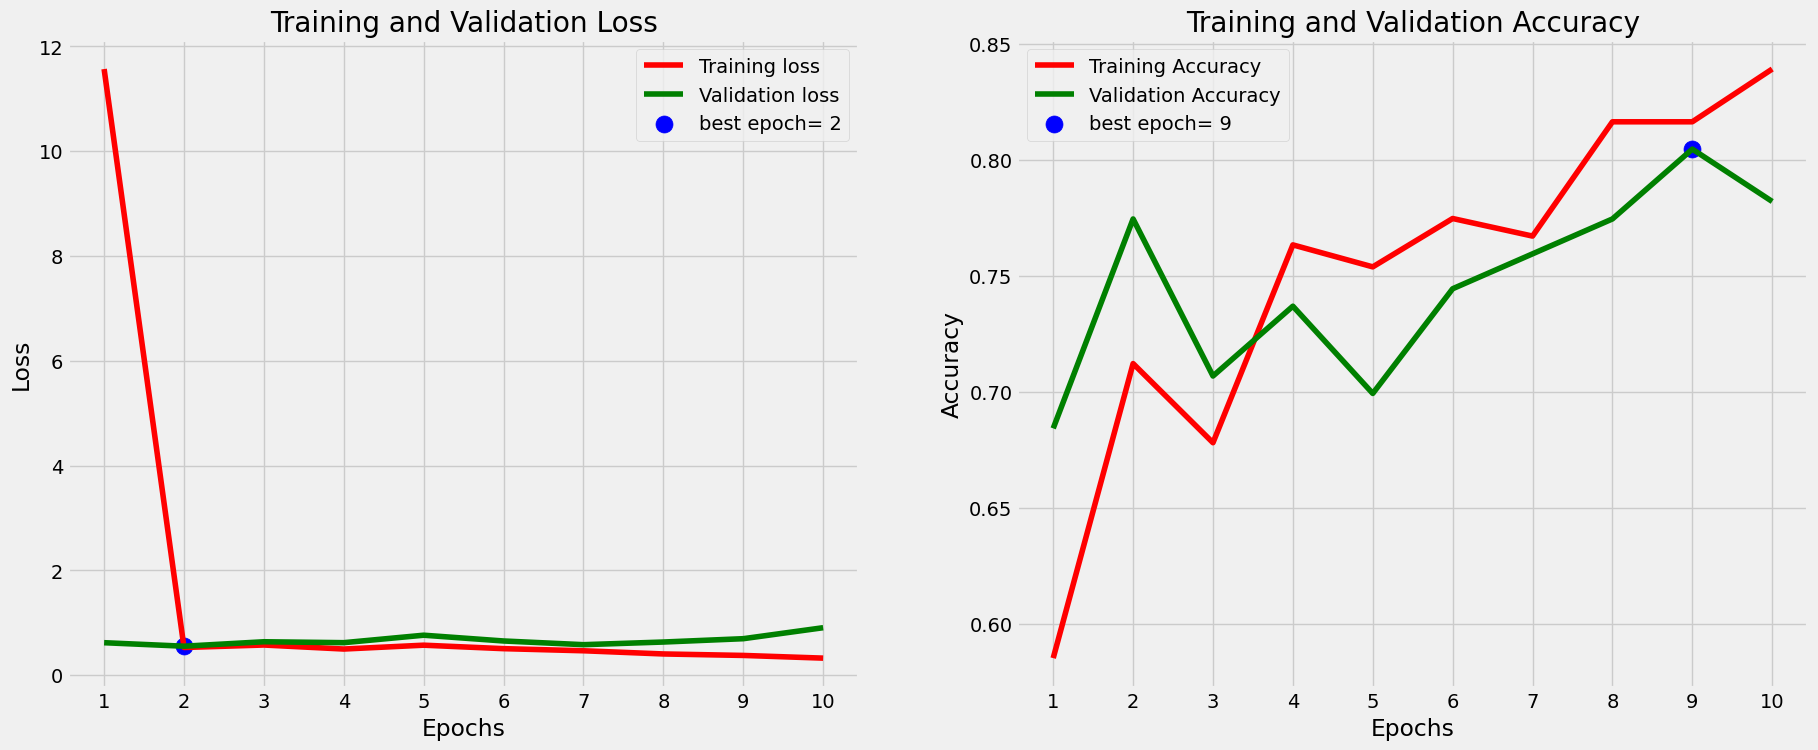

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.xticks(Epochs)
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.xticks(Epochs)
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

<ipython-input-71-01135dd8c8ed>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


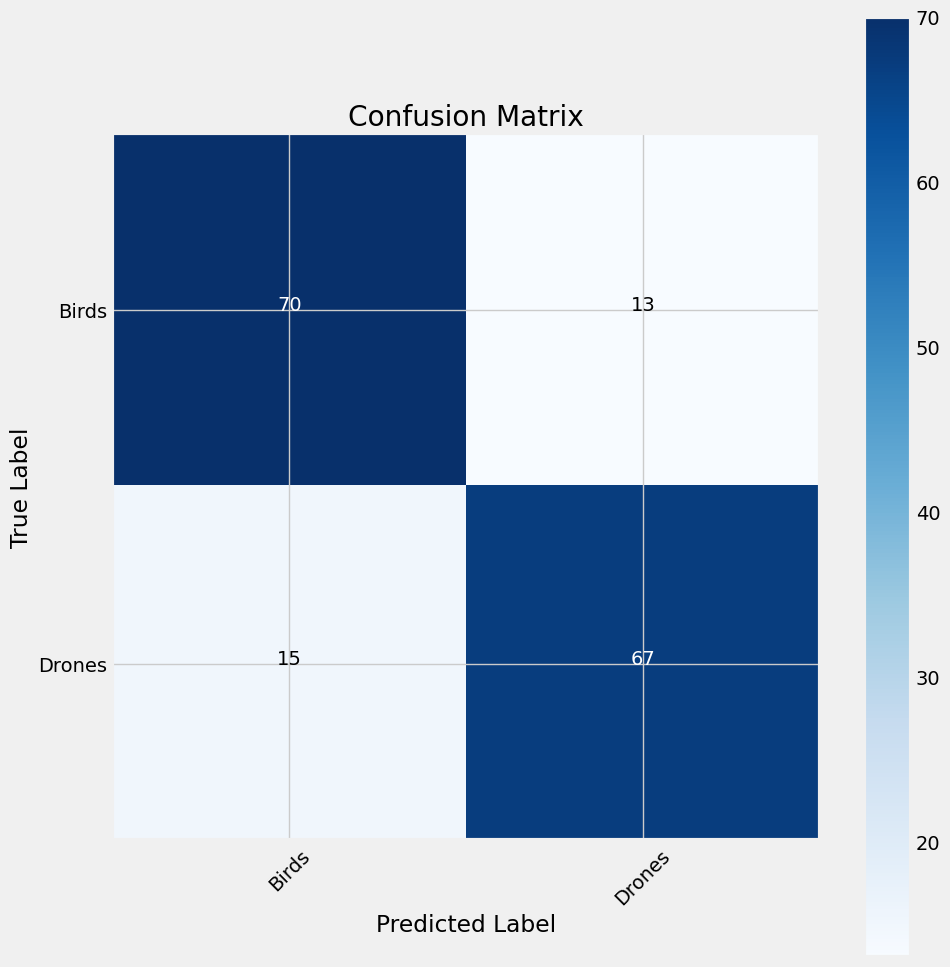

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
model.save('/content/gdrive/MyDrive/ColabNotebooks/Birds/model.h5')